# UTILS & ALGORITHMS

## Utils

In [1]:
import numpy as np
import math

from typing import Tuple, List

def get_player_location(game_map: np.ndarray, symbol : str = "@") -> Tuple[int, int]:
    x, y = np.where(game_map == ord(symbol))
    return (x[0], y[0])

def get_target_location(game_map: np.ndarray, symbol : str = ">") -> Tuple[int, int]:
    x, y = np.where(game_map == ord(symbol))
    return (x[0], y[0])

def is_wall(position_element: int) -> bool:
    obstacles = "|- "
    return chr(position_element) in obstacles

def get_valid_moves(game_map: np.ndarray, current_position: Tuple[int, int]) -> List[Tuple[int, int]]:
    x_limit, y_limit = game_map.shape
    valid = []
    x, y = current_position    
    # North
    if y - 1 > 0 and not is_wall(game_map[x, y-1]):
        valid.append((x, y-1)) 
    # East
    if x + 1 < x_limit and not is_wall(game_map[x+1, y]):
        valid.append((x+1, y)) 
    # South
    if y + 1 < y_limit and not is_wall(game_map[x, y+1]):
        valid.append((x, y+1)) 
    # West
    if x - 1 > 0 and not is_wall(game_map[x-1, y]):
        valid.append((x-1, y))

    return valid

def actions_from_path(start: Tuple[int, int], path: List[Tuple[int, int]]) -> List[int]:
    action_map = {
        "N": 0,
        "E": 1,
        "S": 2,
        "W": 3
    }
    actions = []
    x_s, y_s = start
    for (x, y) in path:
        if x_s == x:
            if y_s > y:
                actions.append(action_map["W"])
            else: actions.append(action_map["E"])
        elif y_s == y:
            if x_s > x:
                actions.append(action_map["N"])
            else: actions.append(action_map["S"])
        else:
            raise Exception("x and y can't change at the same time. oblique moves not allowed!")
        x_s = x
        y_s = y
    
    return actions

def euclidean_distance(point1: Tuple[int, int], point2: Tuple[int, int]) -> float:
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)


def manhattan_distance(point1: Tuple[int, int], point2: Tuple[int, int]) -> int:
    x1, y1 = point1
    x2, y2 = point2
    return abs(x1 - x2) + abs(y1 - y2)

def monster_penalty(game_map: np.ndarray, position: Tuple[int, int], monsters: List[Tuple[int, int]], max_penalty: int = 10) -> int:
    penalty = 0
    for monster in monsters:
        dist = manhattan_distance(position, monster)
        if dist == 0:
            return float('inf')  # Evita i nodi occupati dai mostri
        penalty += max(0, max_penalty - dist)
    return penalty

## Basic Algorithms

In [2]:
import numpy as np

from collections import deque
from queue import PriorityQueue

from typing import Tuple, List
import heapq

def build_path(parent: dict, target: Tuple[int, int]) -> List[Tuple[int, int]]:
    path = []
    while target is not None:
        path.append(target)
        target = parent[target]
    path.reverse()
    return path

def bfs(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int]) -> List[Tuple[int, int]]:
    # Create a queue for BFS and mark the start node as visited
    queue = deque()
    visited = set()
    queue.append(start)
    visited.add(start)

    # Create a dictionary to keep track of the parent node for each node in the path
    parent = {start: None}

    while queue:
        # Dequeue a vertex from the queue
        current = queue.popleft()

        # Check if the target node has been reached
        if current == target:
            print("Target found!")
            path = build_path(parent, target)
            return path

        # Visit all adjacent neighbors of the dequeued vertex
        for neighbor in get_valid_moves(game_map, current):
            if neighbor not in visited:
                queue.append(neighbor)
                visited.add(neighbor)
                parent[neighbor] = current

    print("Target node not found!")
    return None

# ---------------------------------------------

def a_star(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable) -> List[Tuple[int, int]]:
    # initialize open and close list
    open_list = PriorityQueue()
    close_list = []
    # additional dict which maintains the nodes in the open list for an easier access and check
    support_list = {}

    starting_state_g = 0
    starting_state_h = h(start, target)
    starting_state_f = starting_state_g + starting_state_h

    open_list.put((starting_state_f, (start, starting_state_g)))
    support_list[start] = starting_state_g
    parent = {start: None}

    while not open_list.empty():
        # get the node with lowest f
        _, (current, current_cost) = open_list.get()
        # add the node to the close list
        close_list.append(current)

        if current == target:
            print("Target found!")
            path = build_path(parent, target)
            return path

        for neighbor in get_valid_moves(game_map, current):
            # check if neighbor in close list, if so continue
            if neighbor in close_list:
                continue
            # compute neighbor g, h and f values
            neighbor_g = 1 + current_cost
            neighbor_h = h(neighbor, target)
            neighbor_f = neighbor_g + neighbor_h
            parent[neighbor] = current
            neighbor_entry = (neighbor_f, (neighbor, neighbor_g))
            # if neighbor in open_list
            if neighbor in support_list.keys():
                # if neighbor_g is greater or equal to the one in the open list, continue
                if neighbor_g >= support_list[neighbor]:
                    continue
            
            # add neighbor to open list and update support_list
            open_list.put(neighbor_entry)
            support_list[neighbor] = neighbor_g

    print("Target node not found!")
    return None

# ----------------------------------------

def greedy(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable) -> List[Tuple[int, int]]:
    open_list = PriorityQueue()
    open_list.put((h(start, target), start))

    visited = set()
    parent = {start: None}

    while not open_list.empty():
        _, current = open_list.get()

        if current == target:
            print("Target found!")
            return build_path(parent, target)

        visited.add(current)

        for neighbor in get_valid_moves(game_map, current):
            if neighbor not in visited:
                open_list.put((h(neighbor, target), neighbor))
                visited.add(neighbor)
                parent[neighbor] = current

    print("Target node not found!")
    return None

# ----------------------------------------

def dfs(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int]) -> List[Tuple[int, int]]:
    stack = []
    visited = set()
    stack.append(start)
    visited.add(start)

    parent = {start: None}

    while stack:
        current = stack.pop()

        if current == target:
            print("Target found!")
            return build_path(parent, target)

        for neighbor in get_valid_moves(game_map, current):
            if neighbor not in visited:
                stack.append(neighbor)
                visited.add(neighbor)
                parent[neighbor] = current

    print("Target node not found!")
    return None

# ----------------------------------------

def iddfs(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], max_depth: int) -> List[Tuple[int, int]]:
    for depth in range(max_depth + 1):
        print(f"Exploring depth: {depth}")
        path = []
        visited = set()
        if dfs_limited(game_map, start, target, depth, path, visited):
            path.reverse()  # Reverse to get the path from start to target
            return path
    print("Target node not found!")
    return None

def dfs_limited(game_map: np.ndarray, current: Tuple[int, int], target: Tuple[int, int], depth: int,
                path: List[Tuple[int, int]], visited: set) -> bool:
    if current == target:
        path.append(current)
        return True
    if depth <= 0:
        return False

    visited.add(current)
    for neighbor in get_valid_moves(game_map, current):
        if neighbor not in visited:
            if dfs_limited(game_map, neighbor, target, depth - 1, path, visited):
                path.append(current)
                return True
    visited.remove(current)
    return False



# ----------------------------------------

def beam_search(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable, beam_width: int) -> List[Tuple[int, int]]:
    current_nodes = [start]
    parent = {start: None}
    visited = set()

    while current_nodes:
        neighbors = []

        for node in current_nodes:
            if node == target:
                print("Target found!")
                return build_path(parent, target)

            visited.add(node)

            for neighbor in get_valid_moves(game_map, node):
                if neighbor not in visited:
                    neighbors.append((h(neighbor, target), neighbor))
                    parent[neighbor] = node

        if not neighbors:
            break

        neighbors.sort()
        current_nodes = [node for _, node in neighbors[:beam_width]]

    print("Target node not found!")
    return None

# ----------------------------------------

def theta_star(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], h: callable) -> List[Tuple[int, int]]:
    open_list = []
    heapq.heappush(open_list, (0, start))
    came_from = {start: None}
    g_score = {start: 0}
    visited = set()

    while open_list:
        _, current = heapq.heappop(open_list)
        visited.add(current)

        if current == target:
            return build_path(came_from, target)

        for neighbor in get_valid_moves(game_map, current):
            if neighbor in visited:
                continue

            parent = came_from.get(current, None)
            if parent is None:
                parent = current

            if line_of_sight(game_map, parent, neighbor):
                tentative_g_score = g_score[parent] +  euclidean_distance(parent, neighbor)
            else:
                tentative_g_score = g_score[current] + euclidean_distance(current, neighbor)

            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score = tentative_g_score + h(neighbor, target)
                heapq.heappush(open_list, (f_score, neighbor))

    print("Target node not found!")
    return None

def line_of_sight(game_map: np.ndarray, start: Tuple[int, int], end: Tuple[int, int]) -> bool:

    #Determina se c'è una linea di vista diretta tra due punti senza ostacoli.
    x0, y0 = start
    x1, y1 = end
    dx, dy = abs(x1 - x0), abs(y1 - y0)
    sx, sy = 1 if x0 < x1 else -1, 1 if y0 < y1 else -1
    err = dx - dy

    while (x0, y0) != (x1, y1):
        if is_wall(game_map[x0, y0]):
            return False
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return True

# ----------------------------------------

def a_star_with_monsters(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], monsters: List[Tuple[int, int]], h: callable) -> List[Tuple[int, int]]:
    open_list = PriorityQueue()
    closed_list = set()
    support_list = {}

    starting_state_g = 0
    starting_state_h = h(start, target)
    starting_state_f = starting_state_g + starting_state_h

    open_list.put((starting_state_f, (start, starting_state_g)))
    support_list[start] = starting_state_g
    parent = {start: None}

    while not open_list.empty():
        _, (current, current_cost) = open_list.get()
        closed_list.add(current)

        if current == target:
            print("Target found!")
            path = build_path(parent, target)
            return path

        for neighbor in get_valid_moves(game_map, current):
            if neighbor in closed_list:
                continue

            # Calcola il costo g e h
            neighbor_g = 1 + current_cost + monster_penalty(game_map, neighbor, monsters)
            neighbor_h = h(neighbor, target)
            neighbor_f = neighbor_g + neighbor_h
            parent[neighbor] = current

            if neighbor in support_list:
                if neighbor_g >= support_list[neighbor]:
                    continue

            open_list.put((neighbor_f, (neighbor, neighbor_g)))
            support_list[neighbor] = neighbor_g

    print("Target node not found!")
    return None


## Monte Carlo Search Tree

In [13]:
import numpy as np
import random
from typing import Tuple, List, Dict, Set

class MCTSNode:
    def __init__(self, state, parent=None):
        self.state = state # current state represented by the node
        self.parent = parent # reference to the parent node
        self.children = [] # list of child nodes
        self.visits = 0 # number of times this node has been visited
        self.value = 0 # cumulative reward associated with this node
        # orthogonal moves checking
        if parent is None:
            self.path_to_leaf = [state]
        else:
            
            px, py = parent.state
            cx, cy = state
            if abs(px - cx) + abs(py - cy) != 1:  # Verifica che la mossa sia di un solo passo in una direzione
                raise ValueError(f"Invalid move from {parent.state} to {state}")
            self.path_to_leaf = parent.path_to_leaf + [state]
            
        self.min_distance_to_target = float('inf')
        self.visited_states = set() if parent is None else parent.visited_states.copy()
        self.visited_states.add(state)
        
    def is_fully_expanded(self, game_map: np.ndarray, cached_moves: Dict[Tuple[int, int], List[Tuple[int, int]]]) -> bool:
        if self.state not in cached_moves:
            cached_moves[self.state] = get_valid_moves(game_map, self.state)
        return len(self.children) == len([m for m in cached_moves[self.state] if m not in self.visited_states])

    def best_child(self, exploration_weight: float = 1.0, target: Tuple[int, int] = None):
        if not self.children:
            return None
            
        scores = []
        for child in self.children:
            exploitation = child.value / (child.visits + 1e-6)
            exploration = exploration_weight * np.sqrt(np.log(self.visits + 1) / (child.visits + 1e-6))
            
            if target:
                current_distance = manhattan_distance(child.state, target)
                distance_score = 1.0 / (current_distance + 1)
                path_length_penalty = 0.2 * len(child.path_to_leaf)
                revisit_penalty = 0.3 * len(child.visited_states.intersection(self.visited_states))
                
                total_score = exploitation + exploration + distance_score - path_length_penalty - revisit_penalty
            else:
                total_score = exploitation + exploration
                
            scores.append(total_score)
            
        return self.children[np.argmax(scores)]

    def add_child(self, child_state, target: Tuple[int, int]):
        child_node = MCTSNode(child_state, parent=self)
        child_node.min_distance_to_target = manhattan_distance(child_state, target)
        self.children.append(child_node)
        return child_node

def manhattan_distance(pos1: Tuple[int, int], pos2: Tuple[int, int]) -> int:
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def dynamic_reward(path_length: int, current_distance: int, initial_distance: int, 
                  best_distance: float, visited_count: int, cycle_detected: bool) -> float:
    if current_distance == 0:  # Target reached
        path_efficiency = max(0, 1 - (path_length / (initial_distance * 2)))
        return 2.0 + path_efficiency  # Increased reward for reaching target
        
    # Heavily penalize paths with loops
    if cycle_detected:
        return 0.05
        
    progress = (initial_distance - current_distance) / initial_distance
    length_penalty = 0.3 * (path_length / initial_distance)  # Increased length penalty
    revisit_penalty = 0.2 * visited_count  # Increased revisit penalty
    
    return max(0.1, progress - length_penalty - revisit_penalty)

def mcts(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], 
         iterations: int = 1000, exploration_factor: float = 0.3) -> List[Tuple[int, int]]:
    
    root = MCTSNode(start)
    best_path = []
    best_distance = float('inf')
    cached_moves = {}
    
    initial_distance = manhattan_distance(start, target)
    max_reasonable_path_length = initial_distance * 3  # Increased max path length
    
    for iteration in range(iterations):
        node = root
        current_path = set([start])
        
        # Selection with cycle detection
        while node.is_fully_expanded(game_map, cached_moves) and node.children:
            node = node.best_child(exploration_factor, target)
            if node.state in current_path:  # Cycle detected
                break
            current_path.add(node.state)
            
            if node.state == target:
                if len(node.path_to_leaf) < best_distance:
                    best_path = node.path_to_leaf.copy()
                    best_distance = len(node.path_to_leaf)
                break
        
        # Expansion
        if node.state != target:
            valid_moves = cached_moves.get(node.state) or get_valid_moves(game_map, node.state)
            cached_moves[node.state] = valid_moves
            unexplored = [move for move in valid_moves if move not in [child.state for child in node.children] 
                         and move not in node.visited_states]
            
            if unexplored:
                # Prioritize moves that haven't been visited and are closer to target
                new_state = min(unexplored, 
                              key=lambda pos: manhattan_distance(pos, target) + 
                                            len(current_path & {pos}) * 10)
                node = node.add_child(new_state, target)
                current_path.add(new_state)
        
        # Simulation with improved path finding
        current_state = node.state
        simulation_path = set(current_path)
        simulation_steps = 0
        cycle_detected = False
        
        while current_state != target and simulation_steps < max_reasonable_path_length:
            valid_moves = cached_moves.get(current_state) or get_valid_moves(game_map, current_state)
            cached_moves[current_state] = valid_moves
            
            if not valid_moves:
                break
                
            # Improved move selection during simulation
            move_scores = []
            for move in valid_moves:
                distance_to_target = manhattan_distance(move, target)
                visit_penalty = 2.0 if move in simulation_path else 0.0
                progress_score = (manhattan_distance(current_state, target) - distance_to_target)
                
                score = progress_score - visit_penalty + random.random() * 0.1
                move_scores.append(score)
            
            next_move = valid_moves[np.argmax(move_scores)]
            
            if next_move in simulation_path:
                cycle_detected = True
                break
                
            current_state = next_move
            simulation_path.add(current_state)
            simulation_steps += 1
        
        # Calculate reward with improved cycle detection
        final_distance = manhattan_distance(current_state, target)
        reward = dynamic_reward(
            len(simulation_path),
            final_distance,
            initial_distance,
            best_distance,
            len(simulation_path),
            cycle_detected
        )
        
        # Backpropagation
        while node:
            node.visits += 1
            node.value += reward
            node.min_distance_to_target = min(node.min_distance_to_target, final_distance)
            node = node.parent
            
    return best_path if best_path and best_path[-1] == target else []

## Genetic Algorithm

In [6]:
import numpy as np
import random
from typing import Tuple, List
import time
from typing import Dict, Any
import csv
from datetime import datetime

# Side functions

def fitness(path: List[Tuple[int, int]], target: Tuple[int, int], population=None, tabu_paths=None) -> float:
    """
    Calculates fitness score for a path based on distance to target, diversity, and path quality
    Now also considers similarity to tabu paths
    """
    if not path:
        return float('-inf')
    
    last_node = path[-1]
    dist = abs(last_node[0] - target[0]) + abs(last_node[1] - target[1])
    
    # Calculate diversity relative to population
    diversity_score = 0
    if population:
        avg_common_positions = 0
        for other_path in population:
            common_positions = len(set(path).intersection(set(other_path)))
            avg_common_positions += common_positions
        if len(population) > 0:
            avg_common_positions /= len(population)
            diversity_score = -avg_common_positions
    
    # Penalize similarity to tabu paths
    tabu_penalty = 0
    if tabu_paths:
        for tabu_path in tabu_paths:
            common_positions = len(set(path).intersection(set(tabu_path)))
            similarity_ratio = common_positions / len(path)
            tabu_penalty += similarity_ratio * 20  # Forte penalizzazione per similarità con percorsi tabù
    
    # Other calculations
    position_counts = {}
    for pos in path:
        position_counts[pos] = position_counts.get(pos, 0) + 1
    
    repetition_penalty = sum(count - 1 for count in position_counts.values())
    unique_positions = len(set(path))
    progress_score = unique_positions / len(path)
    
    return -(dist + repetition_penalty * 2 + tabu_penalty) + (progress_score * 10) + (diversity_score * 5)

def generate_random_path(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], max_steps: int) -> List[Tuple[int, int]]:
    """
    Generates a random path starting from the initial node.
    The path develops by choosing valid moves until the target is reached or the maximum step limit is reached.
    """
    path = [start]  # Start from the starting node
    current = start
    for _ in range(max_steps):  # Limit the length of the paths
        neighbors = get_valid_moves(game_map, current)  # Get valid moves
        if not neighbors:  # If there are no valid moves, end the path
            break
        current = random.choice(neighbors)  # Choose a random move
        path.append(current)
        if current == target:  # If it reaches the target, stop
            break
    return path

def is_valid_path(path: List[Tuple[int, int]]) -> bool:
    """
    Checks that the path is valid by ensuring that each step is adjacent to the previous one.
    A step is valid if it moves by only one unit horizontally or vertically.
    """
    if not path or len(path) < 2:
        return True
        
    for i in range(1, len(path)):
        prev = path[i-1]
        curr = path[i]
        
        # Check that the movement is by only one unit horizontally or vertically
        dx = abs(curr[0] - prev[0])
        dy = abs(curr[1] - prev[1])
        
        # A step is valid if:
        # - it moves by 1 horizontally and 0 vertically
        # - it moves by 0 horizontally and 1 vertically
        if not ((dx == 1 and dy == 0) or (dx == 0 and dy == 1)):
            return False
            
    return True

def crossover(parent1: List[Tuple[int, int]], parent2: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
    """
    Combines two parent paths to create a new child path,
    ensuring that the split point produces a valid path.
    """
    if len(parent1) < 3 or len(parent2) < 3:
        return random.choice([parent1, parent2])
    
    max_split = min(len(parent1), len(parent2)) - 1
    for _ in range(max_split):  # Try multiple times to find a valid split
        split = random.randint(1, max_split)  # Choose a random split point
        
        # Check if the connection is valid (movement by one unit vertically or horizontally)
        if (
            (abs(parent1[split - 1][0] - parent2[split][0]) == 1 and parent1[split - 1][1] == parent2[split][1]) or
            (parent1[split - 1][0] == parent2[split][0] and abs(parent1[split - 1][1] - parent2[split][1]) == 1)
        ) and parent1[split - 1] != parent2[split]:
            return parent1[:split] + parent2[split:]
    
    # If no valid split is found, return one of the parents
    return random.choice([parent1, parent2])

def mutate(path: List[Tuple[int, int]], game_map: np.ndarray, mutation_rate: float) -> List[Tuple[int, int]]:
    """
    Applies a significant mutation with probability mutation_rate
    """
    if not path or random.random() < mutation_rate:  # Do not mutate if it does not pass the probabilistic check
        return path
    
    # If we pass the probability check, make a significant mutation
    idx = random.randint(0, len(path) - 1)
    current = path[idx]
    new_subpath = [current]
    
    # Generate some random valid steps
    for _ in range(min(5, len(path) - idx)):
        neighbors = get_valid_moves(game_map, new_subpath[-1])
        if not neighbors:
            break
        new_subpath.append(random.choice(neighbors))
    
    return path[:idx] + new_subpath


# Main function
def genetic_alg_func(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], 
                    population_size: int, generations: int, mutation_rate: float, max_steps: int) -> List[List[Tuple[int, int]]]:
    
    population = [generate_random_path(game_map, start, target, max_steps) for _ in range(population_size)]
    list_paths = []
    tabu_paths = []  # Lista dei percorsi che hanno portato a stagnazione
    
    stagnation_counter = 0
    best_fitness = float('-inf')

    for generation in range(generations):
        # Ordina la popolazione usando una fitness che considera i percorsi tabù
        population.sort(key=lambda path: fitness(path, target, population, tabu_paths=tabu_paths), reverse=True)
        
        list_paths.append(population[0])
        current_best_fitness = fitness(population[0], target)
        
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            stagnation_counter = 0
        else:
            stagnation_counter += 1

        # Reset totale se stagnazione
        if stagnation_counter >= 100:
            #print(f"Restart totale alla generazione {generation}.")
            # Aggiungi il percorso corrente alla lista tabù
            tabu_paths.append(population[0])
            population = [generate_random_path(game_map, start, target, max_steps) for _ in range(population_size)]
            stagnation_counter = 0
            best_fitness = float('-inf')

        # Controlla se il target è stato raggiunto
        best_path = population[0]
        if best_path and is_valid_path(best_path) and best_path[-1] == target:
            print(f"Target raggiunto in generazione {generation}")
            return list_paths[-1]

        new_population = []
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(population[:population_size // 2], 2)
            child = crossover(parent1, parent2)
            child = mutate(child, game_map, mutation_rate)
            new_population.append(child)
        
        population = new_population

    print("Target not reached after all generations.")
    return list_paths, generation

# THE ACTUAL CODE TO RUN

In [8]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

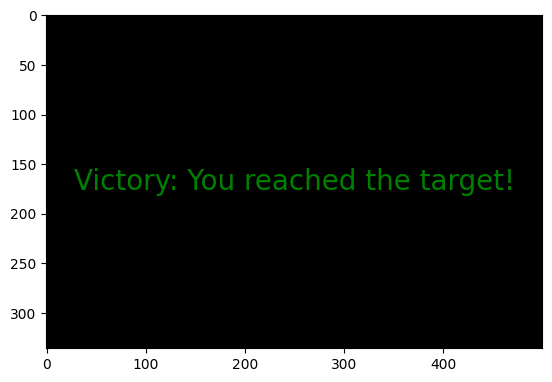

In [11]:
#Create our environment specifying the Map and what keys we have to observe 
env = gym.make("MiniHack-ExploreMaze-Hard-Mapped-v0", observation_keys=("chars", "pixel", "blstats", "message"))
SEED = 0
env.seed(SEED)
state = env.reset()

coordinates = [500, 500]

plt.imshow(state['pixel'][:coordinates[0], :coordinates[1]])

game_map = state['chars']
game = state['pixel']
game_stats = state['blstats']
game_mex = state['message']

#game_map = np.array(game_map)

start = get_player_location(game_map)
target = get_target_location(game_map)
hp = game_stats[6]
print("Agent position:", start)
print("Target position:", target)


# Add Game Over function
def display_game_over():
    plt.text(0.5, 0.5, "Game Over: You were killed by monsters!", 
             fontsize=20, ha='center', va='center', color='red', transform=plt.gca().transAxes)

# Add ictory function
def display_victory():
    plt.text(0.5, 0.5, "Victory: You reached the target!", 
             fontsize=20, ha='center', va='center', color='green', transform=plt.gca().transAxes)

# Choose your algorithm

#path = bfs(game_map, start, target)
#path = dfs(game_map, start, target)
#path = iddfs(game_map, start, target, 29)
#path = greedy(game_map, start, target, manhattan_distance)
#path = a_star(game_map, start, target, manhattan_distance)
#path = theta_star(game_map, start, target, euclidean_distance)
#path = beam_search(game_map, start, target, manhattan_distance, 5)
#path = mcts(game_map, start, target, iterations=2000)
#path = genetic_alg_func(game_map, start, target, 1000, 2000, 0.9, 45)

actions = actions_from_path(start, path[1:])


image = plt.imshow(game[:coordinates[0], :coordinates[1]])
for action in actions:
    s, _, done, _ = env.step(action)  # `done` say to us when the simulation is over
    image.set_data(s['pixel'][:coordinates[0], :coordinates[1]])
    
    
    # If the simulation is done
    if done:
        # If player's hp are equal to 0 it means that he is dead
        if hp == 0: 
            display_game_over()
            break  # Interrupt the smulation

        # Else you have won    
        display_victory()
        break  # Interrupt the smulation


    # Update the game visualization
    display.display(plt.gcf())
    display.clear_output(wait=True)